In [1]:
import numpy as np

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from network import *

from plot_data import *
from data_loading import *

import json

from approaches.gaussian_predictor_levelsets import *
from approaches.gaussian_trainer import *

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.lines import Line2D

seed_everything(42)

Exponential

In [2]:
import torch

class Generator2D:
    def __init__(self, f, matrix_transform, noise_type='gaussian', noise_std=1.0):
        """
        Args:
            f (callable): Fonction f(X) -> (N, 2) (La moyenne conditionnelle)
            matrix_transform (callable): Fonction A(X) -> (N, 2, 2). 
                                         Définit la forme et l'orientation du bruit localement.
            noise_type (str): 'gaussian' ou 'uniform'
            noise_std (float): Facteur global de bruit (si besoin)
        """
        self.f = f
        self.matrix_transform = matrix_transform
        self.noise_type = noise_type
        self.noise_std = noise_std

    def _get_noise(self, n):
        """Génère un vecteur de bruit (n, 2, 1)"""
        if self.noise_type == 'gaussian':
            noise = torch.randn(n, 2)
        elif self.noise_type == 'uniform':
            noise = torch.rand(n, 2) * 2 - 1
        elif self.noise_type == 'exponential':
            noise = torch.distributions.Exponential(rate=1.0).sample((n, 2))
        else:
            raise ValueError(f"Type inconnu: {self.noise_type}")
        
        # On redimensionne pour le produit matriciel : (N, 2) -> (N, 2, 1)
        return (noise * self.noise_std).unsqueeze(2)

    def generate(self, n):
        """
        Génère n échantillons:
        X ~ U[-1, 1]
        Y = f(X) + A(X) @ Noise
        """
        # 1. X ~ U[-1, 1]
        x = 2 * torch.rand(n, 1) - 1

        # 2. Moyenne f(X) -> (n, 2)
        fx = self.f(x)

        # 3. Matrice de covariance "racine" A(X) -> (n, 2, 2)
        A_x = self.matrix_transform(x)

        # 4. Bruit -> (n, 2, 1)
        noise = self._get_noise(n)

        # 5. Application de la matrice: (n, 2, 2) @ (n, 2, 1) -> (n, 2, 1)
        correlated_noise = torch.bmm(A_x, noise).squeeze(2)

        # 6. Y = f(X) + Noise_corrélé
        y = fx + correlated_noise

        return x, y

    def generate_specific_y_given_x(self, x_tensor, n=1):
        """Renvoie n_samples de Y pour chaque X donné"""
        n_input = x_tensor.shape[0]
        
        # Répétition de X pour vectoriser
        x_repeated = x_tensor.repeat_interleave(n, dim=0)
        
        fx = self.f(x_repeated)
        A_x = self.matrix_transform(x_repeated)
        noise = self._get_noise(x_repeated.shape[0])
        
        correlated_noise = torch.bmm(A_x, noise).squeeze(2)
        y_flat = fx + correlated_noise
        
        return y_flat.view(n, 2)

In [3]:
def strange_matrix_transform(x):
    n = x.shape[0]
    
    matrices = torch.eye(2).unsqueeze(0).repeat(n, 1, 1)
    matrices[:, 0, 0] = x.squeeze()**2 + 0.5 
    
    matrices[:, 0, 1] = torch.sin(x.squeeze() * 2)

    matrices[:, 1, 1] = torch.abs(x.squeeze()) + 0.2

    return matrices

def circle_f(x):
    return torch.cat([torch.sin(x*3), torch.cos(x*3)], dim=1)

generator = Generator2D(
    f=circle_f,
    matrix_transform=strange_matrix_transform, # Tes matrices bizarres
    noise_std=1.0,
    noise_type="exponential"
)

x, y = generator.generate(100)

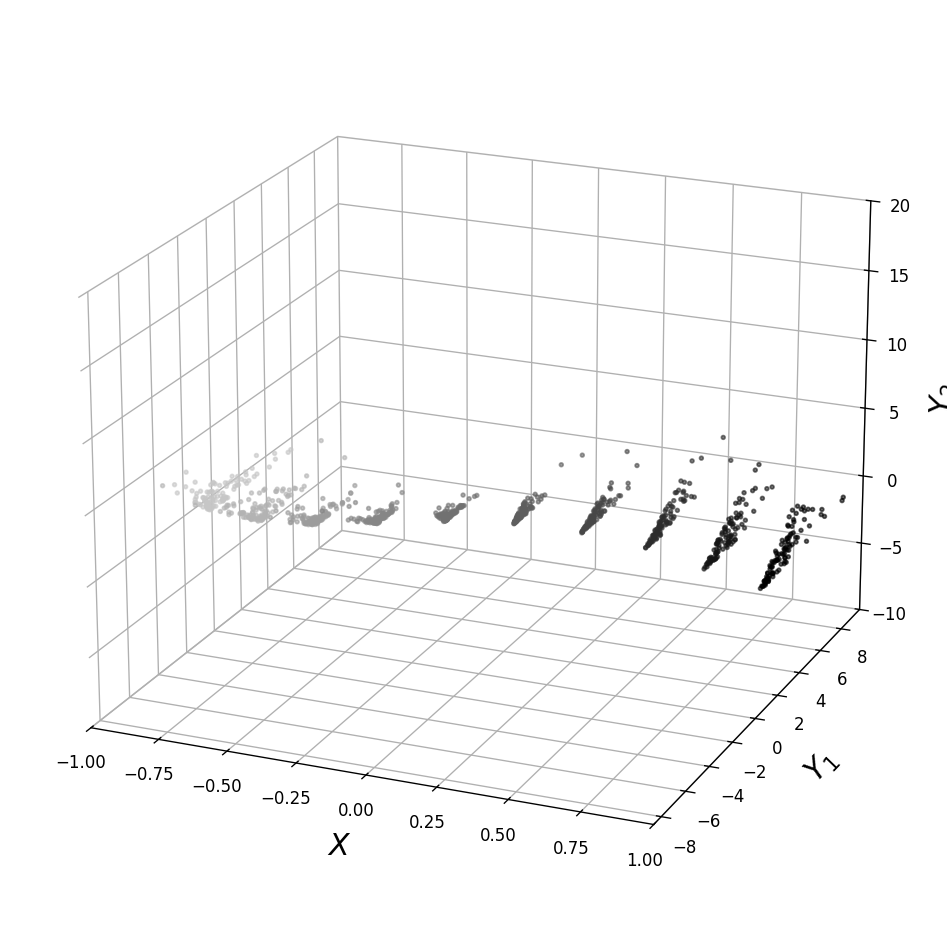

In [4]:
import matplotlib.colors as colmat

def plot_samples(data_generator, x_range=(-1, 1), num_slices=12, n_samples=100):
    
    fig = plt.figure(figsize=(10, 8), dpi=120)
    ax = fig.add_subplot(111, projection='3d')

    xs = np.linspace(x_range[0], x_range[1], num_slices)

    for x_val in xs:
        x_tensor = np.array([x_val]) 
        
        samples = data_generator.generate_specific_y_given_x(torch.tensor(x_tensor, dtype=torch.float32).unsqueeze(0), n=n_samples)

        if hasattr(samples, 'detach'):
            samples = samples.detach().cpu().numpy()
            
        if samples.shape[0] != n_samples and samples.shape[1] == n_samples:
             samples = samples.T

        x_scatter = np.full(n_samples, x_val)
        
        norm = colmat.Normalize(vmin=x_range[0]-1, vmax=x_range[1])
        cmap = cm.Greys

        color = cmap(norm(x_val))

        ax.scatter(
            x_scatter, samples[:, 0], samples[:, 1],
            c=[color],
            s=5,
            alpha=0.6,
            zorder=1
        )


    ax.set_xlabel(r'$X$', fontsize=18, labelpad=10)
    ax.set_ylabel(r'$Y_1$', fontsize=18, labelpad=10)
    ax.set_zlabel(r'$Y_2$', fontsize=18, labelpad=10)
    ax.set_xlim(x_range[0], x_range[1])
    ax.set_zlim(-10, 20)
    
    # Masquer le fond gris des axes pour un rendu "papier" plus propre
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # ax.grid(False) 
    
    # ax.view_init(elev=20, azim=-35)
    ax.view_init(elev=20, azim=-67)
    plt.tight_layout()
    plt.show()

plot_samples(generator, num_slices=10)

In [5]:
n_train = 20_000
n_test = 1_000
n_calibration = 1_000
n_stop = 1_000

dtype = torch.float32

x_train, y_train = generator.generate(n_train)
x_stop, y_stop = generator.generate(n_stop)
x_calibration, y_calibration = generator.generate(n_calibration)
x_test, y_test = generator.generate(n_test)

x_train_tensor = torch.tensor(x_train, dtype=dtype)
y_train_tensor = torch.tensor(y_train, dtype=dtype)
x_stop_tensor = torch.tensor(x_stop, dtype=dtype)
y_stop_tensor = torch.tensor(y_stop, dtype=dtype)
x_calibration_tensor = torch.tensor(x_calibration, dtype=dtype)
y_calibration_tensor = torch.tensor(y_calibration, dtype=dtype)
x_test_tensor = torch.tensor(x_test, dtype=dtype)
y_test_tensor = torch.tensor(y_test, dtype=dtype)

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_5825/308803684.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=dtype)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_5825/308803684.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=dtype)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_5825/308803684.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stop_tensor = torch.tensor(x_stop, dtype=dtype)
/var/fold

In [6]:
seed_everything(42)

input_dim = 1
output_dim = 2
hidden_dim = 128
num_layers = 3
batch_size = 32
num_epochs = 300
lr = 1e-3

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size, shuffle=True)

gaussian_trainer = GaussianTrainer(input_dim, 
                            output_dim,
                            hidden_dim = hidden_dim,
                            num_layers = num_layers
                            )

gaussian_trainer.fit(trainloader, 
                    stoploader,
                    num_epochs=num_epochs,
                    lr=lr,
                    verbose = 2
                    )

center_model = gaussian_trainer.center_model
matrix_model = gaussian_trainer.matrix_model

gaussian_level_sets = GaussianPredictorLevelsets(center_model, matrix_model, dtype=dtype)

/Users/sbraun/Desktop/Gaussian_Conformal_Prediction_V2/experiments/code/approaches/gaussian_trainer.py:112: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2259.)
  z = torch.triangular_solve(diff, L, upper=False)[0]


Epoch 1: Avg NLL Loss = 0.5930 -- Stop loss: 0.3976 -- Best Stop Loss: inf
Epoch 2: Avg NLL Loss = 0.4548 -- Stop loss: 0.3698 -- Best Stop Loss: 0.39757785259280354
Epoch 3: Avg NLL Loss = 0.4205 -- Stop loss: 0.3999 -- Best Stop Loss: 0.3698188121197745
Epoch 4: Avg NLL Loss = 0.4099 -- Stop loss: 0.4324 -- Best Stop Loss: 0.3698188121197745
Epoch 5: Avg NLL Loss = 0.4053 -- Stop loss: 0.3883 -- Best Stop Loss: 0.3698188121197745
Epoch 6: Avg NLL Loss = 0.4078 -- Stop loss: 0.3721 -- Best Stop Loss: 0.3698188121197745
Epoch 7: Avg NLL Loss = 0.3982 -- Stop loss: 0.3584 -- Best Stop Loss: 0.3698188121197745
Epoch 8: Avg NLL Loss = 0.3928 -- Stop loss: 0.3285 -- Best Stop Loss: 0.35841523203998804
Epoch 9: Avg NLL Loss = 0.3913 -- Stop loss: 0.4229 -- Best Stop Loss: 0.32854165614116937
Epoch 10: Avg NLL Loss = 0.3950 -- Stop loss: 0.3652 -- Best Stop Loss: 0.32854165614116937
Epoch 11: Avg NLL Loss = 0.3809 -- Stop loss: 0.3790 -- Best Stop Loss: 0.32854165614116937
Epoch 12: Avg NLL 

In [7]:
alpha = 0.1

center_model = gaussian_trainer.center_model
matrix_model = gaussian_trainer.matrix_model

gaussian_level_sets = GaussianPredictorLevelsets(center_model, matrix_model, dtype=dtype)
gaussian_level_sets.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)

tensor(1.9564)

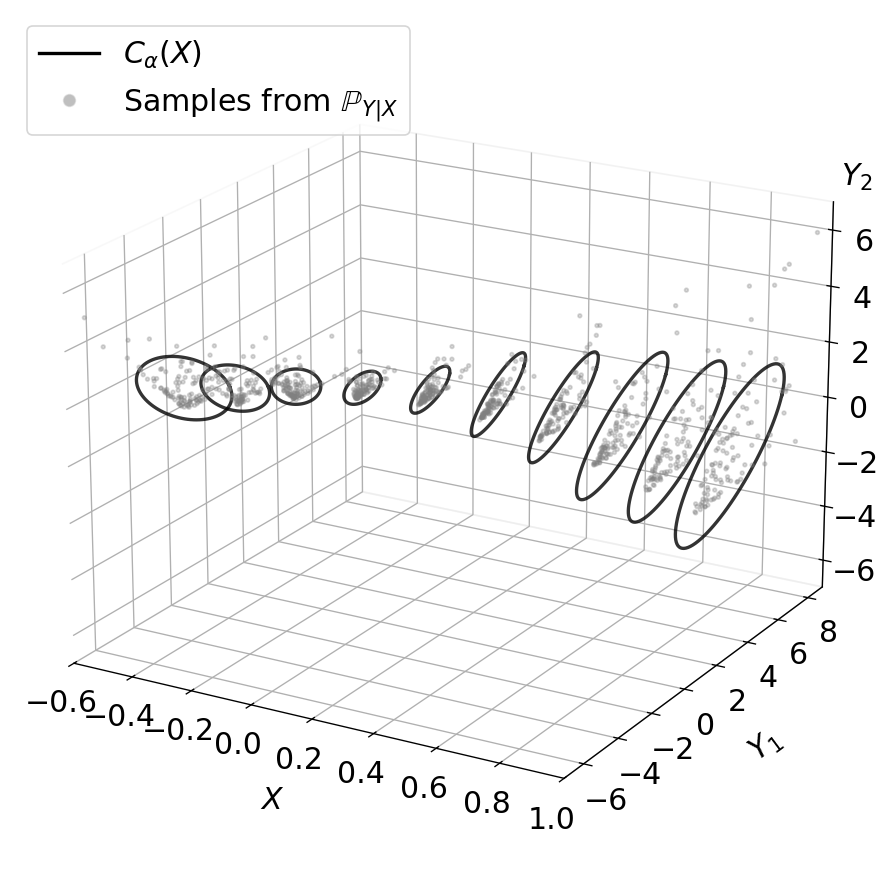

In [21]:
def plot_chdr_with_samples(model, data_generator, x_range=(-1, 1), num_slices=12, n_samples=100, name="gaussian"):
    FS = 18

    fig = plt.figure(figsize=(8, 8), dpi=120) 
    ax = fig.add_subplot(111, projection='3d')
    
    xs = np.linspace(x_range[0], x_range[1], num_slices)
    
    levels = [model.nu_conformal.item()]
    colors = ['black'] 
    linewidths = [2]
    
    for x_val in xs:
        x_tensor = np.array([x_val]) 
        center = model.get_centers(torch.tensor(x_tensor, dtype=torch.float32).unsqueeze(0)).detach().numpy()
        lam = model.get_Lambdas(torch.tensor(x_tensor, dtype=torch.float32).unsqueeze(0)).detach().numpy()
        try:
            inv_lam = np.linalg.inv(lam)
        except np.linalg.LinAlgError:
            continue
        theta = np.linspace(0, 2*np.pi, 100)
        circle_points = np.stack([np.cos(theta), np.sin(theta)], axis=0)
        for r, col, lw in zip(levels, colors, linewidths):
            ellipse_points = center[0][:, None] + inv_lam @ (r * circle_points)
            ellipse_points = ellipse_points.reshape(2, 100)
            ax.plot(np.full_like(ellipse_points[0, :], x_val), ellipse_points[0, :], ellipse_points[1, :], color=col, linewidth=lw, alpha=0.8, zorder=2)
            
        samples = data_generator.generate_specific_y_given_x(torch.tensor(x_tensor, dtype=torch.float32).unsqueeze(0), n=n_samples)
        if hasattr(samples, 'detach'): samples = samples.detach().cpu().numpy()
        if samples.shape[0] != n_samples and samples.shape[1] == n_samples: samples = samples.T
        ax.scatter(np.full(n_samples, x_val), samples[:, 0], samples[:, 1], c='grey', marker='o', s=5, alpha=0.3, zorder=1)

    ax.set_xlabel(r'$X$', fontsize=FS, labelpad=15)
    ax.set_ylabel(r'$Y_1$', fontsize=FS, labelpad=15)
    
    ax.text(0.75, 16, 5, r'$Y_2$', fontsize=FS, fontweight='bold', ha='center')

    ax.set_xlim(x_range[0], x_range[1])
    z_limit = 7
    ax.set_zlim(-z_limit, z_limit)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.tick_params(axis='both', which='major', labelsize=FS)

    legend_elements = [
        Line2D([0], [0], color='black', lw=2, label=r'$C_\alpha(X)$'),
        Line2D([0], [0], marker='o', color='w', label=r'Samples from $\mathbb{P}_{Y|X}$',
               markerfacecolor='grey', markersize=8, alpha=0.5)
    ]
    ax.legend(handles=legend_elements, fontsize=FS, loc='upper left')

    ax.view_init(elev=20, azim=-60)
    

    plt.subplots_adjust(left=0.0, right=0.95, bottom=0.05, top=0.95)
    plt.savefig(f"../figs/3D_plot_{name}.pdf", dpi=300)    
    plt.show()


plot_chdr_with_samples(gaussian_level_sets, generator, num_slices=10, x_range=(-0.6, 1), name="exponential")

In [50]:
generator_gaussian = Generator2D(
    f=circle_f,
    matrix_transform=strange_matrix_transform, 
    noise_std=1.0,
    noise_type="gaussian"
)

n_train = 20_000
n_test = 1_000
n_calibration = 1_000
n_stop = 1_000

dtype = torch.float32

x_train, y_train = generator_gaussian.generate(n_train)
x_stop, y_stop = generator_gaussian.generate(n_stop)
x_calibration, y_calibration = generator_gaussian.generate(n_calibration)
x_test, y_test = generator_gaussian.generate(n_test)

x_train_tensor = torch.tensor(x_train, dtype=dtype)
y_train_tensor = torch.tensor(y_train, dtype=dtype)
x_stop_tensor = torch.tensor(x_stop, dtype=dtype)
y_stop_tensor = torch.tensor(y_stop, dtype=dtype)
x_calibration_tensor = torch.tensor(x_calibration, dtype=dtype)
y_calibration_tensor = torch.tensor(y_calibration, dtype=dtype)
x_test_tensor = torch.tensor(x_test, dtype=dtype)
y_test_tensor = torch.tensor(y_test, dtype=dtype)


/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_19403/2507492426.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=dtype)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_19403/2507492426.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=dtype)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_19403/2507492426.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stop_tensor = torch.tensor(x_stop, dtype=dtype)
/va

In [51]:
seed_everything(42)

input_dim = 1
output_dim = 2
hidden_dim = 128
num_layers = 3
batch_size = 32
num_epochs = 30
lr = 1e-3

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size, shuffle=True)

gaussian_trainer_2 = GaussianTrainer(input_dim, 
                            output_dim,
                            hidden_dim = hidden_dim,
                            num_layers = num_layers
                            )

gaussian_trainer_2.fit(trainloader, 
                    stoploader,
                    num_epochs=num_epochs,
                    lr=lr,
                    verbose = 2
                    )

center_model = gaussian_trainer_2.center_model
matrix_model = gaussian_trainer_2.matrix_model

gaussian_level_sets_2 = GaussianPredictorLevelsets(center_model, matrix_model, dtype=dtype)

Epoch 1: Avg NLL Loss = 0.4555 -- Stop loss: 0.4105 -- Best Stop Loss: inf
Epoch 2: Avg NLL Loss = 0.3843 -- Stop loss: 0.3730 -- Best Stop Loss: 0.4105222972575575
Epoch 3: Avg NLL Loss = 0.3683 -- Stop loss: 0.3802 -- Best Stop Loss: 0.3730248094070703
Epoch 4: Avg NLL Loss = 0.3705 -- Stop loss: 0.4665 -- Best Stop Loss: 0.3730248094070703
Epoch 5: Avg NLL Loss = 0.3591 -- Stop loss: 0.3737 -- Best Stop Loss: 0.3730248094070703
Epoch 6: Avg NLL Loss = 0.3580 -- Stop loss: 0.3831 -- Best Stop Loss: 0.3730248094070703
Epoch 7: Avg NLL Loss = 0.3502 -- Stop loss: 0.3787 -- Best Stop Loss: 0.3730248094070703
Epoch 8: Avg NLL Loss = 0.3474 -- Stop loss: 0.3629 -- Best Stop Loss: 0.3730248094070703
Epoch 9: Avg NLL Loss = 0.3450 -- Stop loss: 0.3712 -- Best Stop Loss: 0.36293248063884676
Epoch 10: Avg NLL Loss = 0.3410 -- Stop loss: 0.3569 -- Best Stop Loss: 0.36293248063884676
Epoch 11: Avg NLL Loss = 0.3442 -- Stop loss: 0.3924 -- Best Stop Loss: 0.3569004504242912
Epoch 12: Avg NLL Los

In [52]:
alpha = 0.1

center_model = gaussian_trainer_2.center_model
matrix_model = gaussian_trainer_2.matrix_model

gaussian_level_sets_2 = GaussianPredictorLevelsets(center_model, matrix_model, dtype=dtype)
gaussian_level_sets_2.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)

tensor(2.1861)

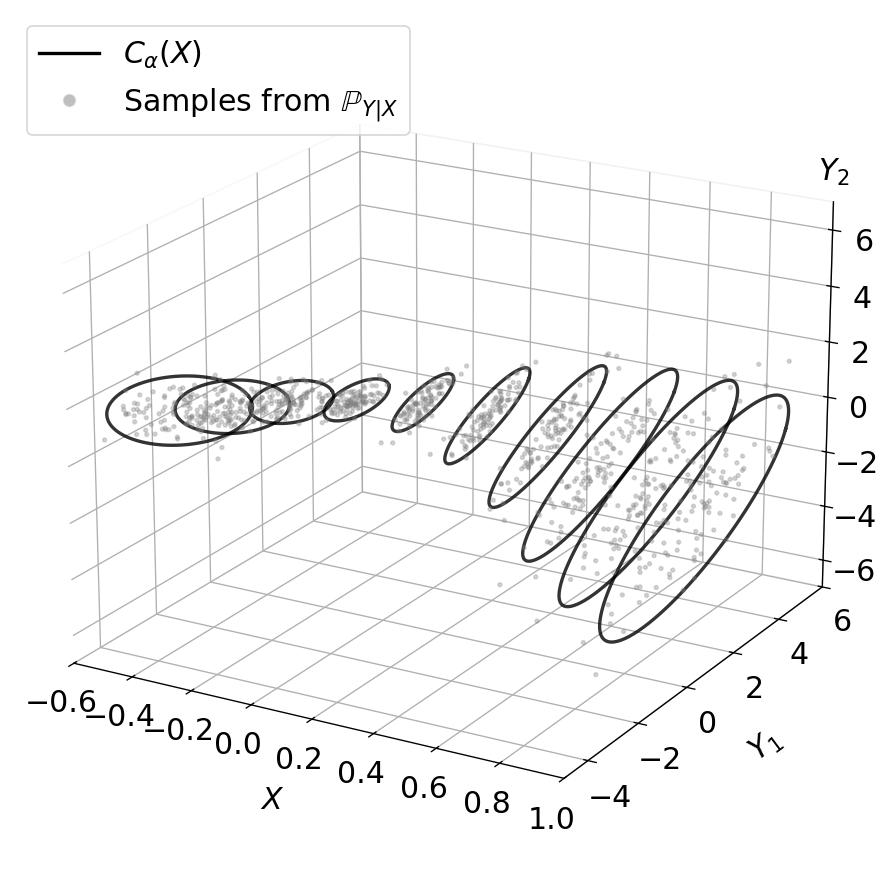

In [ ]:
def plot_chdr_with_samples(model, data_generator, x_range=(-1, 1), num_slices=12, n_samples=100, name="gaussian"):
    FS = 18

    fig = plt.figure(figsize=(8, 8), dpi=120) 
    ax = fig.add_subplot(111, projection='3d')
    
    xs = np.linspace(x_range[0], x_range[1], num_slices)
    
    levels = [model.nu_conformal.item()]
    colors = ['black'] 
    linewidths = [2]
    
    for x_val in xs:
        x_tensor = np.array([x_val]) 
        center = model.get_centers(torch.tensor(x_tensor, dtype=torch.float32).unsqueeze(0)).detach().numpy()
        lam = model.get_Lambdas(torch.tensor(x_tensor, dtype=torch.float32).unsqueeze(0)).detach().numpy()
        try:
            inv_lam = np.linalg.inv(lam)
        except np.linalg.LinAlgError:
            continue
        theta = np.linspace(0, 2*np.pi, 100)
        circle_points = np.stack([np.cos(theta), np.sin(theta)], axis=0)
        for r, col, lw in zip(levels, colors, linewidths):
            ellipse_points = center[0][:, None] + inv_lam @ (r * circle_points)
            ellipse_points = ellipse_points.reshape(2, 100)
            ax.plot(np.full_like(ellipse_points[0, :], x_val), ellipse_points[0, :], ellipse_points[1, :], color=col, linewidth=lw, alpha=0.8, zorder=2)
            
        samples = data_generator.generate_specific_y_given_x(torch.tensor(x_tensor, dtype=torch.float32).unsqueeze(0), n=n_samples)
        if hasattr(samples, 'detach'): samples = samples.detach().cpu().numpy()
        if samples.shape[0] != n_samples and samples.shape[1] == n_samples: samples = samples.T
        ax.scatter(np.full(n_samples, x_val), samples[:, 0], samples[:, 1], c='grey', marker='o', s=5, alpha=0.3, zorder=1)

    ax.set_xlabel(r'$X$', fontsize=FS, labelpad=15)
    ax.set_ylabel(r'$Y_1$', fontsize=FS, labelpad=15)
    
    ax.text(0.45, 14, 3.2, r'$Y_2$', fontsize=FS, fontweight='bold', ha='center')

    ax.set_xlim(x_range[0], x_range[1])
    z_limit = 7
    ax.set_zlim(-z_limit, z_limit)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.tick_params(axis='both', which='major', labelsize=FS)

    legend_elements = [
        Line2D([0], [0], color='black', lw=2, label=r'$C_\alpha(X)$'),
        Line2D([0], [0], marker='o', color='w', label=r'Samples from $\mathbb{P}_{Y|X}$',
               markerfacecolor='grey', markersize=8, alpha=0.5)
    ]
    ax.legend(handles=legend_elements, fontsize=FS, loc='upper left')

    ax.view_init(elev=20, azim=-60)
    

    plt.subplots_adjust(left=0.0, right=0.95, bottom=0.05, top=0.95)
    plt.savefig(f"../figs/3D_plot_{name}.pdf", dpi=300)    
    plt.show()

plot_chdr_with_samples(gaussian_level_sets_2, generator_gaussian, num_slices=10, x_range=(-0.6, 1), name="gaussian")